In [166]:
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None

#from sklearn.datasets import load_boston

import statsmodels.api as sm

from typing import Dict, List, Tuple, Text

#Plot Graph
import matplotlib.pyplot as plt
import seaborn as sns



#Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBRegressor

# Cleaning

In [96]:
df = pd.read_csv('cleaned_csv') #From Louis Combine
df = df.set_index('sofifa_id')
#Drop for anylsis only
#later should be use sofifa_id to merge together
drop_col = ['player_url','long_name', 'short_name', 'dob', 'real_face', 'release_clause_eur', 'team_position',
           'player_tags', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position',
           'nation_jersey_number', 'player_traits']
df = df.drop(columns = drop_col)
#drop for ls	st	rs	lw	lf	cf	rf	rw	lam	cam	ram	lm	lcm	cm	rcm	rm	lwb	ldm	cdm	rdm	rwb	lb	lcb	cb	rcb	rb
exclude_col = df.columns[62:-1]
print(exclude_col)
df = df.drop(columns = exclude_col)
#Assumption: nationality, club, preferred_foot and body_type would not affect the potential score
df = df.drop(columns = ['nationality', 'club', 'preferred_foot', 'body_type'])
display(df)

Index(['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb'],
      dtype='object')


,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,player_positions,international_reputation,weak_foot,skill_moves,work_rate,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,28,170,72,94,95,111000000,550000,"RW, CF",5,4,4,Medium/Low,92.0,88.0,86.0,95.0,24.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,84,94,71,89,85,96,89,90,82,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,74,0.0,25,25,22,6,11,15,14,8,2016
20801,30,185,80,93,93,85500000,475000,"LW, LM",5,4,5,High/Low,92.0,93.0,80.0,91.0,33.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,83,95,86,82,87,93,88,79,72,92,91,94,93,94,63,94,94,89,79,93,63,34,95,81,85,0.0,22,31,23,7,11,15,14,11,2016
9014,31,180,80,90,90,56000000,250000,"RM, LM, RW",5,2,4,High/Low,92.0,86.0,82.0,92.0,32.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,80,85,52,86,86,93,87,83,76,92,93,93,93,91,91,86,61,78,65,90,47,39,89,84,80,0.0,29,26,26,10,8,11,5,15,2016
167495,29,193,92,90,90,58000000,250000,GK,5,4,1,Medium/Medium,0.0,0.0,0.0,0.0,0.0,0.0,85.0,87.0,91.0,86.0,60.0,90.0,25,25,25,54,25,25,25,25,53,31,58,61,43,88,35,42,78,44,83,25,29,30,25,90,37,0.0,25,25,25,88,89,91,90,86,2016
176580,28,182,85,90,90,69000000,300000,ST,5,4,4,High/Medium,83.0,88.0,79.0,87.0,42.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,77,91,79,82,89,90,86,84,64,93,88,79,86,91,60,92,69,86,76,88,78,41,94,84,85,0.0,30,45,38,27,25,31,33,37,2016
183277,24,173,74,89,91,74000000,240000,LM,4,4,4,High/Medium,90.0,82.0,84.0,92.0,32.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,82,83,57,86,79,95,82,79,82,90,93,87,92,86,90,79,59,74,63,82,54,41,88,86,86,0.0,25,27,22,11,12,6,8,8,2016
41236,33,195,95,89,89,40500000,220000,ST,5,4,4,Medium/Low,73.0,90.0,81.0,85.0,31.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,76,90,76,84,92,87,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,0.0,25,41,27,13,15,10,9,12,2016
190871,23,174,68,88,93,71500000,230000,LW,5,5,5,High/Medium,90.0,80.0,72.0,92.0,30.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,71,85,62,72,83,94,78,78,72,92,91,91,92,86,84,77,61,86,45,70,56,36,87,72,81,0.0,21,24,33,9,9,15,15,11,2016
164240,30,183,79,88,88,38000000,200000,CB,4,3,3,High/High,74.0,57.0,73.0,73.0,90.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,60,38,82,79,63,68,61,73,81,80,75,80,75,85,68,78,96,80,81,71,79,91,59,74,71,0.0,92,92,90,9,12,5,9,10,2016


In [97]:
# Position
def postition_grouping(value) -> Text:
    forward = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw']
    mid = ['lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'ldm', 'cdm', 'rdm']
    back = ['lwb', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
    keeper = ['gk']
    
    position_dict = {}
    position_dict['forward'] = forward
    position_dict['mid'] = mid
    position_dict['back'] = back
    position_dict['keeper'] = keeper
    
    value_list = value.replace(' ','').split(',')
    
    for v in value_list:
        for position, items in position_dict.items():
            if v.lower() in items:
                return (position)
    print('Error')
df['position'] = df['player_positions'].apply(lambda x: postition_grouping(x))
df = df.drop(columns = 'player_positions')

In [98]:
#work_rate ranking 
def work_rate_convert(value):
    value = value.split('/')
    prefix = value[0]
    suffix = value[1]
    
    group = {}
    group['Low'] = 0
    group['Medium'] = 3
    group['High'] = 6
    
    level = {}
    level['Low'] = 0
    level['Medium'] = 1
    level['High'] = 2
    
    group_score = group[prefix]
    level_score = level[suffix]
    rank = group_score + level_score
    return rank
df['work_rate_rank'] = df['work_rate'].apply(lambda x:work_rate_convert(x))
#pd.unique(df['work_rate'])
df = df.drop(columns = ['work_rate'])

In [99]:
#Year, potential, no need to consider in this case
df = df.drop(columns = ['year', 'potential'])

In [100]:
#Separate for different position analysis
df_dict = {}
df_dict['overall'] = df.copy()
df_dict['forward'] = df[df['position'] == 'forward']
df_dict['mid'] = df[df['position'] == 'mid']
df_dict['back'] = df[df['position'] == 'back']
df_dict['keeper'] = df[df['position'] == 'keeper']

# Discrimination Reduction (Supervised Learning y:overall)

In [127]:
#3. Stepwise Regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  international_reputation       with p-value 0.0
Add  pace                           with p-value 0.0
Add  movement_agility               with p-value 0.0
Add  mentality_interceptions        with p-value 0.0
Add  weak_foot                      with p-value 0.0
Add  age                            with p-value 0.0
Add  mentality_positioning          with p-value 0.0
Add  attacking_short_passing        with p-value 0.0
Add  movement_acceleration          with p-value 0.0
Add  attacking_heading_accuracy     with p-value 0.0
Add  goalkeeping_kicking            with p-value 0.0
Add  weight_kg                      with p-value 0.0
Drop pace                           with p-value 0.662555


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  wage_eur                       with p-value 0.0
Add  gk_diving                      with p-value 0.0
Add  pace                           with p-value 0.0
Add  defending                      with p-value 0.0
Add  defending_sliding_tackle       with p-value 0.0
Add  shooting                       with p-value 0.0
Add  movement_reactions             with p-value 0.0
Add  mentality_composure            with p-value 0.0
Add  value_eur                      with p-value 0.0
Drop international_reputation       with p-value 0.225285
Add  skill_dribbling                with p-value 0.0
Add  skill_moves                    with p-value 0.0
Drop movement_agility               with p-value 0.160444
Add  skill_ball_control             with p-value 0.0
Add  gk_positioning                 with p-value 0.0
Add  dribbling                      with p-value 0.0
Add  power_strength                 with p-value 0.0
Add  physic                         with p-value 2.02477e-253
Add  gk_reflexes           

In [161]:
#Run Stepwise
def var_reduce(df_dict)->Dict:
    output_dict = {}
    
    for key, df in df_dict.items():
        df_x = df.drop(columns = ['overall', 'position'])
        df_y = df[['overall']]
        result = stepwise_selection(df_x, df_y)
        print(key)
        print('resulting features:')
        print(result)
        include_list = result[:20]  #Just use first 20 x columns for analysis 
        exclude_list = set(df.columns) - set(include_list)
        output_df = df.drop(columns = exclude_list)
        output_df = output_df.join(df_y) #Add back overall
        output_dict[key] = output_df
        #Save
        output_df.to_csv(f'stepwise_df/stepwise_{key}.csv', index = False) #For next time do not need to run
    return output_dict

#stepwise_dict = var_reduce(df_dict)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  international_reputation       with p-value 0.0
Add  pace                           with p-value 0.0
Add  movement_agility               with p-value 0.0
Add  mentality_interceptions        with p-value 0.0
Add  weak_foot                      with p-value 0.0
Add  age                            with p-value 0.0
Add  mentality_positioning          with p-value 0.0
Add  attacking_short_passing        with p-value 0.0
Add  movement_acceleration          with p-value 0.0
Add  attacking_heading_accuracy     with p-value 0.0
Add  goalkeeping_kicking            with p-value 0.0
Add  weight_kg                      with p-value 0.0
Drop pace                           with p-value 0.662555


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  wage_eur                       with p-value 0.0
Add  gk_diving                      with p-value 0.0
Add  pace                           with p-value 0.0
Add  defending                      with p-value 0.0
Add  defending_sliding_tackle       with p-value 0.0
Add  shooting                       with p-value 0.0
Add  movement_reactions             with p-value 0.0
Add  mentality_composure            with p-value 0.0
Add  value_eur                      with p-value 0.0
Drop international_reputation       with p-value 0.225285
Add  skill_dribbling                with p-value 0.0
Add  skill_moves                    with p-value 0.0
Drop movement_agility               with p-value 0.160444
Add  skill_ball_control             with p-value 0.0
Add  gk_positioning                 with p-value 0.0
Add  dribbling                      with p-value 0.0
Add  power_strength                 with p-value 0.0
Add  physic                         with p-value 2.02477e-253
Add  gk_reflexes           

Add  weight_kg                      with p-value 3.6126e-06
Add  height_cm                      with p-value 4.28457e-07
Add  defending_standing_tackle      with p-value 2.48982e-05
Add  goalkeeping_kicking            with p-value 2.63042e-05
Add  mentality_penalties            with p-value 0.000204911
Add  goalkeeping_diving             with p-value 0.0002497
Add  power_jumping                  with p-value 0.000303838
Add  movement_sprint_speed          with p-value 0.000811518
Add  goalkeeping_positioning        with p-value 0.00752756
Add  weak_foot                      with p-value 0.00826658
mid
resulting features:
['pace', 'movement_agility', 'age', 'attacking_short_passing', 'wage_eur', 'shooting', 'movement_reactions', 'skill_dribbling', 'power_stamina', 'passing', 'mentality_composure', 'skill_ball_control', 'dribbling', 'physic', 'skill_fk_accuracy', 'movement_balance', 'attacking_volleys', 'value_eur', 'attacking_heading_accuracy', 'mentality_positioning', 'skill_curve', 'w

# Correlation Heatmap Analysis

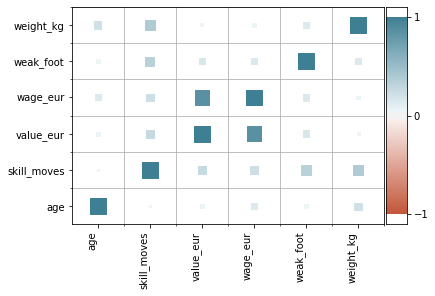

In [251]:
# def heatmap(x, y, size):
#     #fig, ax = plt.subplots()
#     plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
#     ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
#     ###Color###
#     n_colors = 256 # Use 256 colors for the diverging color palette #For 0
#     palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
#     color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

#     def value_to_color(val):
#         val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
#         ind = int(val_position * (n_colors - 1)) # target index in the color palette
#         return palette[ind]
    
    
    
#     # Mapping from column names to integer coordinates
#     x_labels = [v for v in sorted(x.unique())]
#     y_labels = [v for v in sorted(y.unique())]
#     x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
#     y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
#     size_scale = 250
#     ax.scatter(
#         x=x.map(x_to_num), # Use mapping for x
#         y=y.map(y_to_num), # Use mapping for y
#         s=size * size_scale, # Vector of square sizes, proportional to size parameter
#         c=size.apply(value_to_color),
#         marker='s' # Use square as scatterplot marker
#     )
    
#     # Show column labels on the axes
#     ax.set_xticks([x_to_num[v] for v in x_labels])
#     ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
#     ax.set_yticks([y_to_num[v] for v in y_labels])
#     ax.set_yticklabels(y_labels)
    
    
#     #Add the grid
#     ax.grid(False, 'major')
#     ax.grid(True, 'minor')
#     ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
#     ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
#     #Adjust the square position
#     ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
#     ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    

#     # ...
    
#     # Add color legend on the right side of the plot
#     ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

#     col_x = [0]*len(palette) # Fixed x coordinate for the bars
#     bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

#     bar_height = bar_y[1] - bar_y[0]
#     ax.barh(
#         y=bar_y,
#         width=[5]*len(palette), # Make bars 5 units wide
#         left=col_x, # Make bars start at 0
#         height=bar_height,
#         color=palette,
#         linewidth=0
#     )
#     ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
#     ax.grid(False) # Hide grid
#     ax.set_facecolor('white') # Make background white
#     ax.set_xticks([]) # Remove horizontal ticks
#     ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
#     ax.yaxis.tick_right() # Show vertical ticks on the right
    

# corr = testing[testing.columns[:6]].corr()
# corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
# corr.columns = ['x', 'y', 'value']
# heatmap(
#     x=corr['x'],
#     y=corr['y'],
#     size=corr['value'].abs()
# )


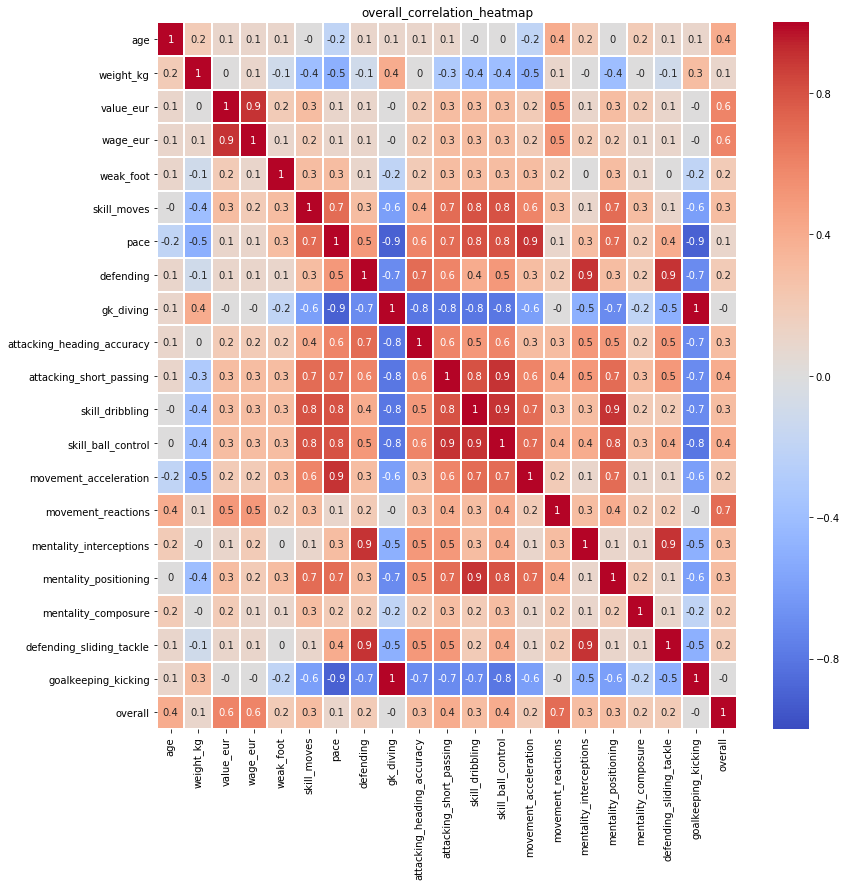

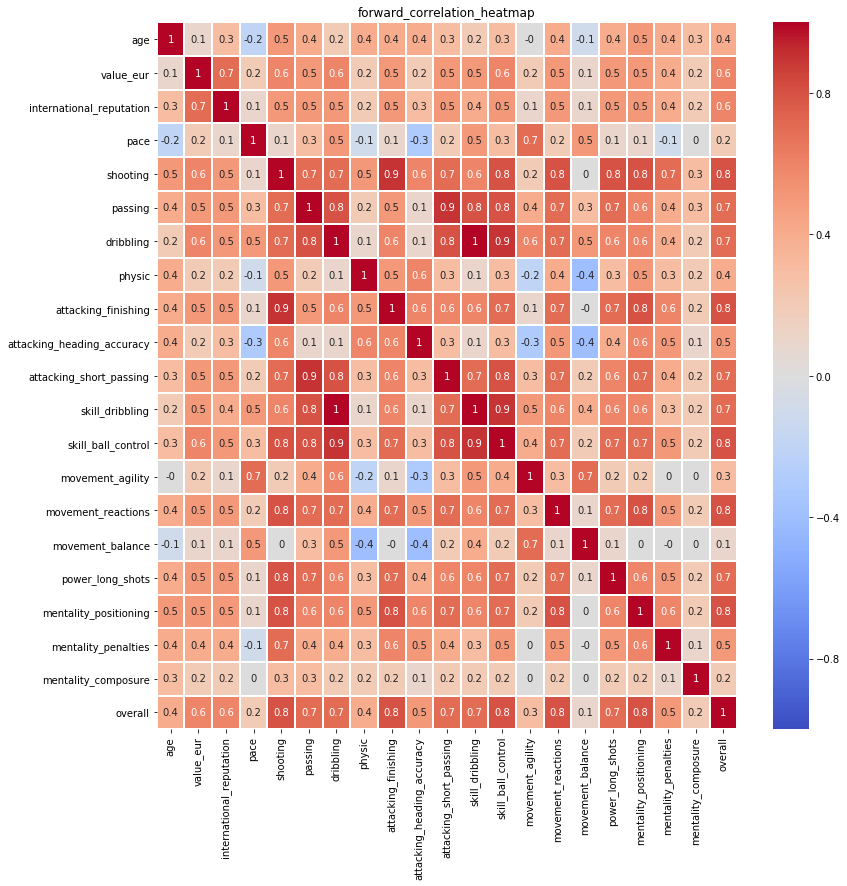

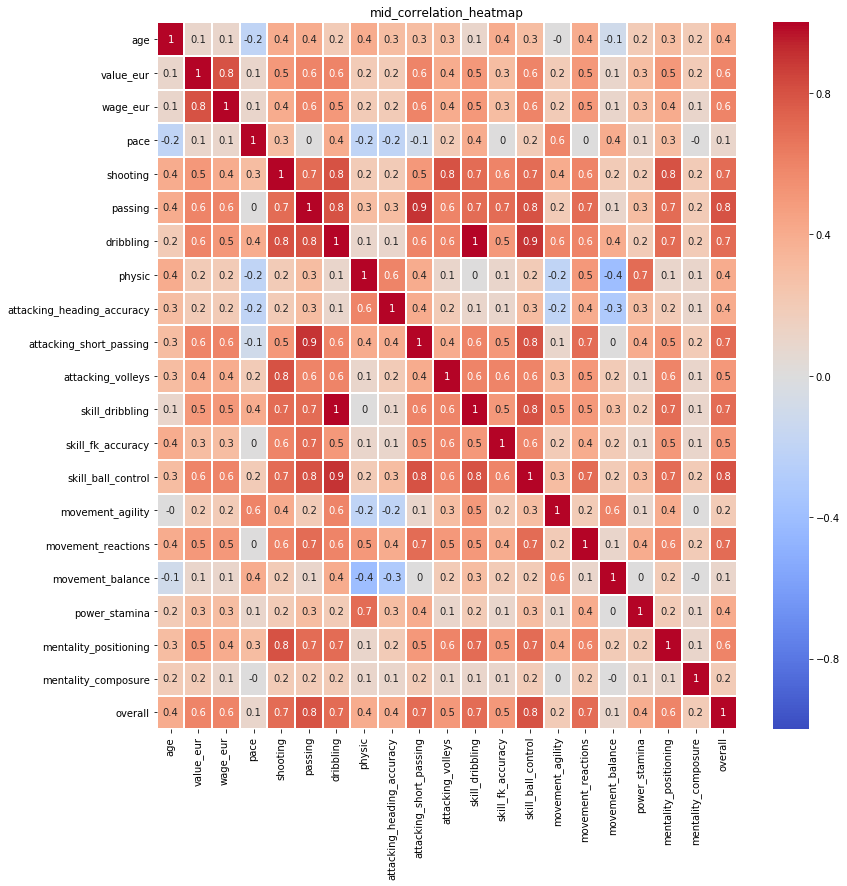

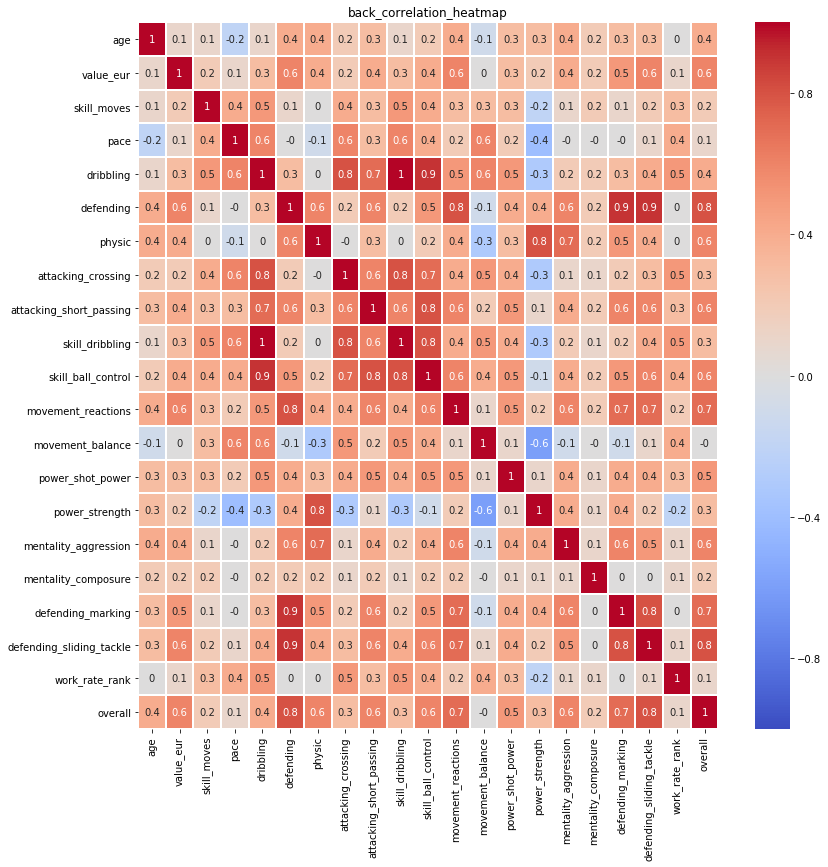

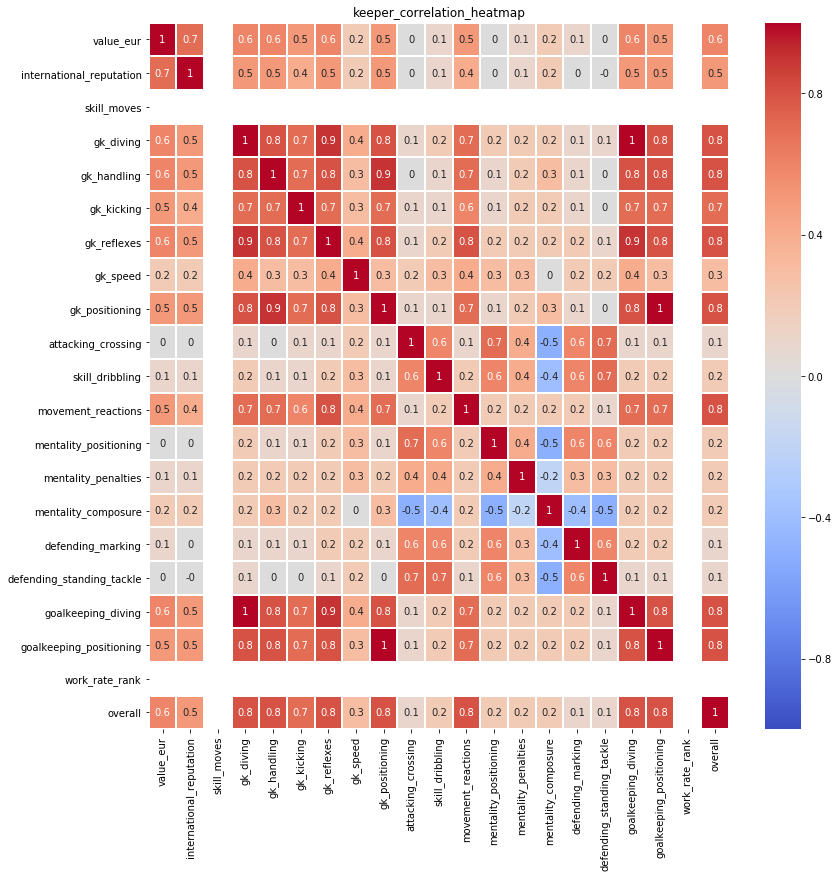

In [282]:
#plot heatmap
for key, item in stepwise_dict.items():
    #corr
    corr = item.corr().round(1)
    fig, ax = plt.subplots(figsize=(13,13))  
    ax.set_title(f'{key}_correlation_heatmap')
    sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, ax = ax)
    fig.savefig(f'correlation_heatmap/{key}.png', bbox_inches="tight")

## Correlation Heatmap Finding
r >=0.7

overall: movement_reaction

forward: shooting, passing, dribbing, attacking_short_passing, skill_dribbling, skill_ball_control,
         movment_reaction, power_long_shots, mentality_positioning
         
mid:     shooting, passing, dribbling, attacking_short_passing, skill_dribbling, skill_ball_control, 
         movement_reaction
         
back:    defending, movement_reaction, defending_making, defending_sliding_tackle

keeper:  gk_diving, gk_handling, gk_kicking, gk_reflexes , gk_positioning , movement_reaction, goalkeeping_diving, goalkeeping_positioning

For keeper: they are only Medium/Low work rate and only one skill_moves